<a href="https://colab.research.google.com/github/jvallalta/ia-medicina/blob/main/GeneracionSintentica_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generación de imágenes médicas sintéticas 

En este notebook implementaremos una DCGAN capaz de generar imágenes médicas sintéticas tomando como referencia el dataset MedNIST.

Utilizaremos MONAI para realizar algunas tareas de carga y transformación.


# Imports
Importamos los paquetes necesarios.

In [2]:
!pip install -qU "monai[ignite]==0.3.0rc2"

%matplotlib inline

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch

import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import compute_roc_auc
from monai.networks.nets import densenet121
from monai.transforms import (
    AddChannel,
    Compose,
    LoadPNG,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.utils import set_determinism

print_config()

     |████████████████████████████████| 290 kB 8.6 MB/s 
     |████████████████████████████████| 103 kB 63.6 MB/s 
MONAI version: 0.3.0rc2
Python version: 3.7.11 (default, Jul  3 2021, 18:01:19)  [GCC 7.5.0]
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102

Optional dependencies:
Pytorch Ignite version: 0.3.0
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.5.0
gdown version: 3.6.4
TorchVision version: 0.10.0+cu102
ITK version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Importamos algunas utilides de PyTorch y definimos una función que nos resultará útil para visualizar las imágenes durante el entrenamiento de la GAN.

In [3]:
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
torch.manual_seed(0) # Set for testing purposes, please do not change!


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Conjunto de datos MedNIST

In [4]:
#Creamos un directorio temporal para alojar los datos
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpoaw8k9cr


El conjunto de datos de MedNIST se obtuvo de varios conjuntos de TCIA, el RSNA Bone Age Challenge y el conjunto de datos de rayos X de tórax de los NIH.

El conjunto de datos fue proporcionado por el Dr. Bradley J. Erickson M.D., Ph.D. (Departamento de Radiología, Clínica Mayo) bajo la licencia Creative Commons CC BY-SA 4.0.

Vamos a descargar este conjunto de datos a continuación y extraerlo en nuestro directorio de datos MONAI temporal.

In [5]:

resource = "https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

61841408/61834679 Downloading MedNIST.tar.gz: [==============================]
downloaded file: /tmp/tmpoaw8k9cr/MedNIST.tar.gz.
Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.


In [6]:
#Datos del dataset
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


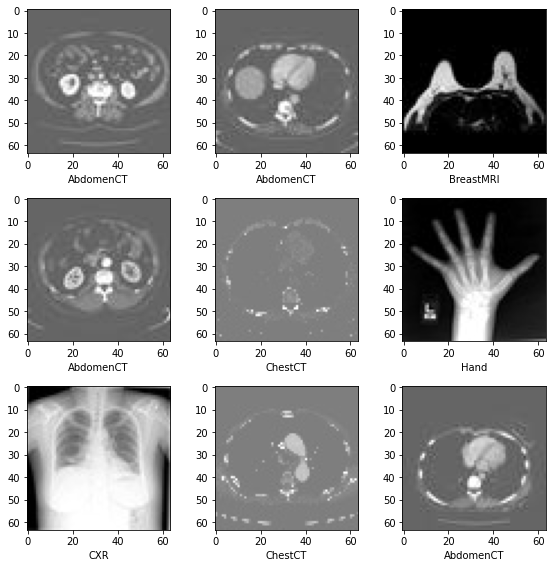

In [7]:
#Visualizamos algunas imágenes al azar
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [9]:
imagenes_manos = []

for i in range(len(image_class)):
  if image_class[i]==4:
    imagenes_manos.append(image_files_list[i])

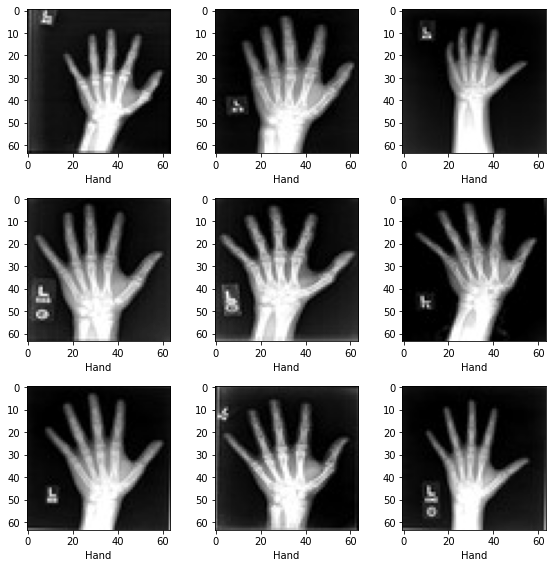

In [12]:
#Visualizamos algunas imágenes al azar
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(10000, size=9)):
    im = PIL.Image.open(imagenes_manos[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel('Hand')
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [13]:
manos = [4 for i in range(len(imagenes_manos))]
len(manos)

10000

In [22]:
train_transforms = Compose(
    [
        LoadPNG(image_only=True),
        AddChannel(),
        ScaleIntensity(minv=-1,maxv=1),
        RandRotate(range_x=15, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
    ]
)

# DCGAN

In [16]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride),
                nn.Tanh()
                #### END CODE HERE ####
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [17]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride)
                
                #### END CODE HERE ####
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [23]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

num_workers = 2

class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(imagenes_manos, manos, train_transforms)
dataloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [24]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Step 500: Generator loss: 0.714543046116829, discriminator loss: 0.6620739783048629


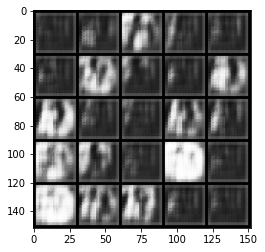

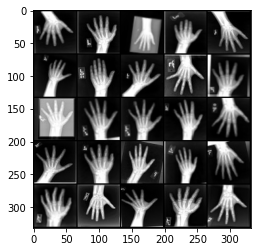

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Step 1000: Generator loss: 0.7096588785648342, discriminator loss: 0.6827746093273177


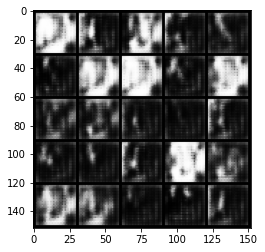

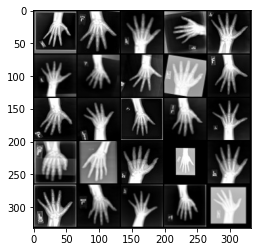

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
n_epochs = 200
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
